In [4]:
import os
import cv2
import numpy as np

In [14]:
base_path = "data/raw"
def load_images_from_folder(base_path, image_size=(128, 128)):
    X_raw = []
    y_labels = []

    class_names = sorted(os.listdir(base_path))  # Ensures consistent label order

    for label_index, class_name in enumerate(class_names):
        class_path = os.path.join(base_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for filename in os.listdir(class_path):
            if filename.endswith('.jpg'):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale

                if img is not None:
                    img_resized = cv2.resize(img, image_size)
                    X_raw.append(img_resized)
                    y_labels.append(label_index)

    return np.array(X_raw), np.array(y_labels), class_names

#### We get
- X_raw → shape (N, 128, 128) — image data

- y_labels → shape (N,) — numeric labels

- class_names → list of defect class names (for mapping back)

In [ ]:
base_path = "data/raw"
class_names = sorted(os.listdir(base_path))
for label_index, class_name in enumerate(class_names):
    print(label_index)
    print(class_name)


#### HOG feature extractraction
Convert each image into a 1D feature vector using HOG (Histogram of Oriented Gradients) — a classic method for texture and edge-based feature extraction.
##### What Does It Do? (Simple Analogy)
- Imagine you divide an image into small square patches (cells), and in each patch:

- Look at the direction in which pixels are changing (gradient direction)

- Count how many pixels point in each direction

- Make a histogram of those directions

In [21]:
from skimage.feature import hog

def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    hog_features = []

    for img in images:
        features = hog(img,
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
        hog_features.append(features)

    return np.array(hog_features)

Classification Report:

                 precision    recall  f1-score   support

        crazing       0.74      0.95      0.83        42
      inclusion       0.75      0.96      0.84        49
        patches       0.71      0.58      0.64        52
 pitted_surface       0.76      0.60      0.67        52
rolled-in_scale       0.96      1.00      0.98        45
      scratches       0.85      0.73      0.79        48

       accuracy                           0.79       288
      macro avg       0.79      0.80      0.79       288
   weighted avg       0.79      0.79      0.78       288



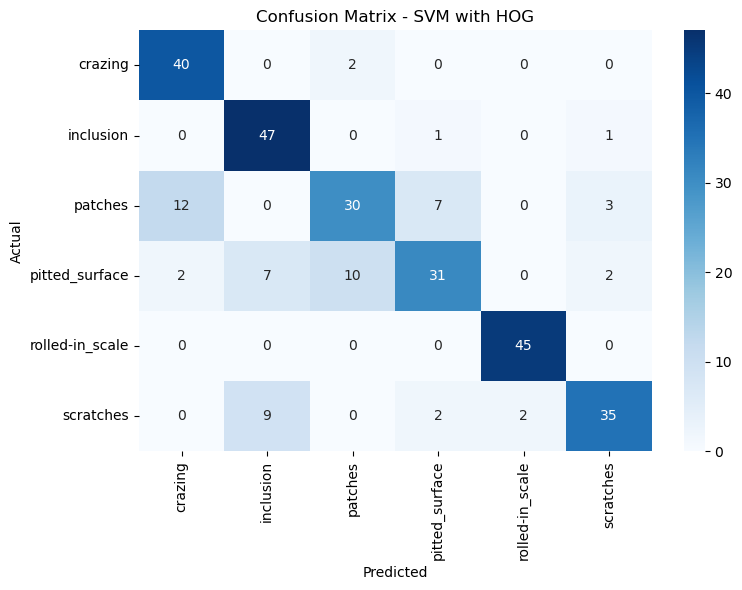

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_raw, y_labels, class_names = load_images_from_folder("data/raw")
X_hog = extract_hog_features(X_raw)

# 1. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_hog, y_labels, test_size=0.2, random_state=42)

# 2. Create and train SVM
clf = SVC(kernel='linear', C=1.0)
clf.fit(X_train, y_train)

# 3. Predict and evaluate
y_pred = clf.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

# 4. Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM with HOG")
plt.tight_layout()
plt.show() 

| Metric                                  | Meaning                                                          |
| --------------------------------------- | ---------------------------------------------------------------- |
| **Precision**                           | Of all images predicted as *that class*, how many were correct?  |
| 👉 Low precision = more false positives |                                                                  |
| **Recall**                              | Of all true images *of that class*, how many did the model find? |
| 👉 Low recall = more false negatives    |                                                                  |
| **F1-score**                            | Harmonic mean of precision and recall                            |
| 👉 Good summary metric                  |                                                                  |
| **Support**                             | Number of true samples in the test set for that class            |


| Class                | Precision | Recall | F1   | Interpretation                                         |
| -------------------- | --------- | ------ | ---- | ------------------------------------------------------ |
| **rolled-in\_scale** | 0.96      | 1.00   | 0.98 | 🔥 Perfect recall — it caught *all* of them            |
| **crazing**          | 0.74      | 0.95   | 0.83 | ⚠️ Very good recall, but some false positives          |
| **patches**          | 0.71      | 0.58   | 0.64 | ⚠️ Struggled a bit — maybe overlaps with other classes |


### It gets ~80% of test samples right, but struggles a bit with patches,pitted_surface and scratches, which it sometimes confuses with other classes. But, a solid job overall, especially with rolled-in scale and inclusion.